# Collecting data

In [ ]:
!pip install -U telethon


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.2/702.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26346 sha256=85c0a9a1cc3f1f579cf23ffc7eb0b9df795e94ebcc81b30004700b3c44822e11
  Stored in directory: /root/.cache/pip/wheels/d6/84/5f/ea6aef85a93c7e1922486369874f4740a5642d261e09c59140
Successfully built pyaes


In [ ]:
from telethon.sync import TelegramClient
from telethon.sessions import SQLiteSession
from telethon.tl.functions.channels import GetFullChannelRequest
import asyncio
import nest_asyncio
import time
import json
from telethon.tl.types import PeerChannel
import pandas as pd
import os
from telethon.tl.custom.message import Message
from telethon import functions, types
from telethon.tl.types import InputMessagesFilterEmpty, InputMessagesFilterPhotos, InputMessagesFilterVideo, InputMessagesFilterPhotoVideo, InputMessagesFilterDocument, InputMessagesFilterUrl, InputMessagesFilterGif, InputMessagesFilterVoice, InputMessagesFilterMusic, InputMessagesFilterChatPhotos, InputMessagesFilterRoundVideo, InputMessagesFilterRoundVoice, InputMessagesFilterGeo, InputMessagesFilterContacts, InputMessagesFilterMyMentions, InputMessagesFilterPinned #Import necessary filters
from telethon.tl.types import MessageEntityTextUrl, MessageEntityMention
import re

In [ ]:

# Replace with your API credentials
api_id = '-'
api_hash = '-'
# channel_username = ['rad_fems', 'megabitch',  'r_anarchy', 'kosa_media']'
# channel_username = 'aviva_md', 'vlad_chastnyi_privatnyi_butylka', ''m_d_channel_1'
channel_username = 'vestnikformul'
nest_asyncio.apply()


In [ ]:
async def check_mentions(post, client):
    mentioned_posts = []
    # Check entities in the message
    original = post
    if post.entities:
        for entity in post.entities:
            if isinstance(entity, MessageEntityTextUrl):
                url = entity.url
                if 't.me/' in url:
                    mentioned_posts.append(url)
            elif isinstance(entity, MessageEntityMention):
                mention = post.message[entity.offset: entity.offset + entity.length]
                mentioned_posts.append(mention)

    #то что выше выдает ссылку а нам нужно только имя канала чтоы найти его id
    pattern = r'https://t\.me/([^/]+)'
    mentioned_channels = []
    for post in mentioned_posts:
        match = re.search(pattern, post)
        if match:
            channel_username = match.group(1)
            mentioned_channels.append(channel_username) #у нас появились названия самих каналов
    name_and_id = []
    for channel_username in set(mentioned_channels):
      try:
            if channel_username.startswith('+'):  #to handle private links
                result = await client(functions.channels.ImportChatInviteRequest(channel_username))
                channel_entity = result.chats[0]
                name_and_id.append((channel_entity.title, channel_entity.id))
            else:
                channel_entity = await client.get_entity(channel_username)
                name_and_id.append((channel_username, channel_entity.id))
      except:
           print(f"Could not find entity for {channel_username}")
    return name_and_id

In [ ]:
async def main():
    retries = 3
    while retries > 0:
        try:
            async with TelegramClient('session1', api_id, api_hash) as client:

                await client.start()

                messages = await client.get_messages(channel_username, limit=1000)

                messages_data = []

                for message in messages:
                    message_info = {}
                    if message.text is None:
                        continue


                    message_info['message_id'] = message.id
                    message_info['date'] = message.date.isoformat()
                    message_info['text'] = message.text
                    message_info['via_bot'] = message.via_bot_id
                    message_info['sender_id'] = message.sender_id


                    if message.peer_id:
                        if message.peer_id.channel_id:
                            message_info['channel_id'] = message.peer_id.channel_id
                            message_info['channel_username'] = channel_username
                        elif message.peer_id.user_id:
                            message_info['user_id'] = message.peer_id.user_id


                    if message.forward:
                      try:
                        forward_entity = await client.get_entity(message.forward.chat_id)
                        message_info['original_channel_id'] = forward_entity.id
                        message_info['original_channel_name'] = forward_entity.title
                        message_info['original_channel_id'] = message.forward.chat_id
                        message_info['original_post_author'] = message.forward.post_author
                        message_info['original_date'] = message.forward.date.isoformat()
                      except:
                        message_info['original_channel_id'] = None
                        message_info['original_post_author'] = None
                        message_info['original_date'] = None



                    #To get the comments
                    message_info['comments'] = []
                    comments_info = {}
                    try:
                        async for comment in client.iter_messages(channel_username, reply_to=message.id):
                                  comments_info = {
                                      'comment_id': comment.id,
                                      'user_id': comment.sender_id,
                                      'text': comment.text,
                                      'date': comment.date.isoformat(),
                                  }
                                  message_info['comments'].append(comments_info)
                    except Exception as e:
                             message_info['comments'] = []
                            print(f"Error fetching replies for message {message.id}: {e}")


                    #to get the mentions of other channels
                    mentioned_posts = []
                    post = await client.get_messages(channel_username, ids=message.id)
                    mentioned_posts = await check_mentions(post, client)
                    if mentioned_posts:
                        message_info['mentioned_posts'] = mentioned_posts
                    messages_data.append(message_info)



                with open('messages_data.json', 'w', encoding='utf-8') as f:
                    json.dump(messages_data, f, ensure_ascii=False, indent=4)



                break
        except Exception as e:
            print('overall error')
            print(f"Error: {e}")
            retries -= 1
            await asyncio.sleep(1)

await main()

Could not find entity for addlist
Could not find entity for +vLmOtpVp9UQzNTYx
Could not find entity for +vLmOtpVp9UQzNTYx
Could not find entity for addlist
Could not find entity for underskytruthbot?start=donate
Could not find entity for underskytruthbot?start=contact
Could not find entity for addlist


In [ ]:
import json
import pandas as pd

with open('messages_data.json', 'r', encoding='utf-8') as f:
    comments_data = json.load(f)


df = pd.DataFrame(comments_data)
print(df.head())


In [ ]:
df.to_csv('comments_data.csv', index=False, encoding='utf-8')

Getting info about all the channels

In [ ]:
import pandas as pd
import glob
import os

json_dir = "/content"

json_files = glob.glob(os.path.join(json_dir, "*.json"))

data_frames = []

for json_file in json_files:
    try:

        df = pd.read_json(json_file)
        data_frames.append(df)
    except Exception as e:
        print(f"Error reading {json_file}: {e}")

final_df = pd.concat(data_frames, ignore_index=True)

final_df.to_csv("anti_combined_data.csv", index=False)



# Sentiment analysis

## Creating a separate column that contains just the texts of the comments

In [ ]:
com = df

In [ ]:
com.isna().sum()

,0
message_id,0
date,0
text,0
via_bot,4321
sender_id,0
channel_id,0
channel_username,0
comments,0
original_channel_id,4263
original_channel_name,4263


In [ ]:
com = com[com['comments'].str.len() != 0] #cleaning

In [ ]:
com['comments_text'] = None
overall_amount = 0
for i in com.index:
  comments = []
  for j in range(len(com.at[i, 'comments'])):
    if com.at[i, 'comments'][j]['text'] is None or com.at[i, 'comments'][j]['text'] == '':
      continue
    comments.append(com.at[i, 'comments'][j]['text'])
  overall_amount += len(comments)
  com.at[i, 'comments_text'] = comments

In [ ]:
com.to_csv("data_with_comments_cleaned.csv", index=False)

In [ ]:
print(overall_amount)

163677


## Calculating sentiment

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment-rusentiment")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import ast

def split_text(text, max_length=512):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

def sentiment_of_topic(df):
  for i in df.index:
    post = df.loc[i]
    comment_sentiment = []
    # a = ast.literal_eval(post['comments_text'])
    a = post['comments_text']

    if not isinstance(a, list):
        print(f"Skipping post {i} due to invalid 'comments_text' type: {type(a)}")
        print(a)
        continue

    #computing sentiments for each individual comment
    for com in a:
        chunks = split_text(com)
        results = [classifier(chunk) for chunk in chunks] #splitting into chunks because the model does not work with more than 512 tokens
        overall_score = 0
        label = 0


        #calculating overall for each comm
        overall_score_positive = 0
        overall_score_negative = 0
        overall_score_neutral = 0
        neu=0
        neg=0
        pos=0

        for score in results:
          score = score[0]

          if score['label'] == 'NEUTRAL':
             overall_score_neutral += score['score']
             neu += 1
          if score['label'] == 'POSITIVE':
             overall_score_positive += score['score']
             pos += 1
          if score['label'] == 'NEGATIVE':
             overall_score_negative += score['score']
             neg += 1

          #so we dont divide by 0; does affect the overall because numerator = 0
        if neu == 0:
            neu = 1
        if neg == 0:
            neg = 1
        if pos == 0:
            pos = 1

        if overall_score_neutral >= overall_score_negative and overall_score_neutral >= overall_score_positive:
            overall_score = overall_score_neutral/neu - overall_score_negative/neg - overall_score_positive/pos
            label = 'neutral'
        if overall_score_negative >= overall_score_neutral and overall_score_negative >= overall_score_positive:
            overall_score = overall_score_negative/neg - overall_score_neutral/neu - overall_score_positive/pos
            label = 'negative'
        if overall_score_positive >= overall_score_neutral and overall_score_positive >= overall_score_negative:
            overall_score = overall_score_positive/pos - overall_score_neutral/neu - overall_score_negative/neg
            label = 'positive'
        comment_sentiment.append((label, overall_score)) #now for each post we have a list of sentiments\


#computing polarisation and prevailing sentiment for the topic
    positive_score = 0
    negative_score = 0
    neutral_score = 0
    polar_score = 0
    sentiment = 0

    for label, overall_score in comment_sentiment:
       if label == 'positive':
        positive_score += overall_score
        sentiment += overall_score
       if label == 'negative':
        negative_score += overall_score
        sentiment -= overall_score
       if label == 'neutral':
        neutral_score += overall_score
    try:
        overall_polar_score = 1 - neutral_score/len(comment_sentiment) - abs(negative_score- positive_score)/len(comment_sentiment)
        overall_sentiment = sentiment/len(comment_sentiment)

    except Exception as e:
                print(e)
                print(comment_sentiment)
                print(a)
                print(post)
                break
    df.at[i, 'overall_polar_score'] = overall_polar_score
    df.at[i, 'overall_sentiment'] = overall_sentiment


  return df



# text = pd.read_csv('/content/text_comments.csv')
text = com
text = sentiment_of_topic(text)


In [ ]:
text.to_csv("anti_text_1000_anotherone.csv", index=False)

In [ ]:
text.shape

(2175, 16)

## Analysing the sentiment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('anti_text_1000_anotherone.csv')
# df.to_csv('anti_text_1000_anotherone.csv', index=True)

In [ ]:
df

,message_id,date,text,via_bot,sender_id,channel_id,channel_username,comments,original_channel_id,original_channel_name,original_post_author,original_date,mentioned_posts,comments_text,overall_polar_score,overall_sentiment
0,5145,2025-01-10 10:59:26+00:00,"**Ебанат, разбивший утром окно в курской школе...",NaN,-1001921078737,1921078737,vlad_chastnyi_privatnyi_butylka,"[{'comment_id': 264652, 'user_id': 7224293346,...",NaN,NaN,NaN,NaN,NaN,"['Что за тёлка такая, что на терракты пробивае...",0.404937,-0.085371
1,5142,2025-01-10 09:15:18+00:00,**В Курске долбаеб напал на школу**\n\nНападен...,NaN,-1001921078737,1921078737,vlad_chastnyi_privatnyi_butylka,"[{'comment_id': 264628, 'user_id': 1819716498,...",NaN,NaN,NaN,NaN,NaN,"['Долбоеб, мог бы пару русснявых подсвинков за...",0.095387,-0.254367
2,5136,2025-01-10 08:36:04+00:00,NaN,NaN,-1001921078737,1921078737,vlad_chastnyi_privatnyi_butylka,"[{'comment_id': 264648, 'user_id': 5824010666,...",NaN,NaN,NaN,NaN,NaN,"['Шляпа ноутбук, не для игр))))', 'агрессия не...",0.359637,-0.053200
3,5135,2025-01-10 08:32:00+00:00,Компьютерные игры нужно запретить в России!!!!...,NaN,-1001921078737,1921078737,vlad_chastnyi_privatnyi_butylka,"[{'comment_id': 264649, 'user_id': 1246031125,...",NaN,NaN,NaN,NaN,NaN,"['Зато смотреть на гнилые анусы полезно', 'про...",0.237215,-0.317586
4,5134,2025-01-10 08:30:04+00:00,❗️Геймеры в России смогут входить в игры тольк...,NaN,-1001921078737,1921078737,vlad_chastnyi_privatnyi_butylka,"[{'comment_id': 264646, 'user_id': 1246031125,...",NaN,NaN,NaN,NaN,NaN,"['Пацаны, возвращаемся на торренты', 'Яндекс.С...",0.297970,-0.129417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,7175,2025-01-02 10:54:24+00:00,Множество серьезных нападений на полицейских и...,NaN,-1001429264495,1429264495,aviva_md,"[{'comment_id': 203110, 'user_id': 7234993531,...",NaN,NaN,NaN,NaN,"[['aviva_md', 1429264495]]",['Само правительство и способствует падению де...,0.055324,-0.322586
2171,7166,2024-12-29 09:08:31+00:00,Как РСП воспитывает очередного аленяку... \n\n...,NaN,-1001429264495,1429264495,aviva_md,"[{'comment_id': 203940, 'user_id': 6207681677,...",NaN,NaN,NaN,NaN,"[['aviva_md', 1429264495]]","['Накл ее', 'Вот так эти конченые РСП хи и кал...",0.505438,0.000000
2172,7008,2024-11-22 12:01:50+00:00,В метро во всех картинках виноват мужчина.\n\n...,NaN,-1001429264495,1429264495,aviva_md,"[{'comment_id': 203473, 'user_id': 5245283938,...",NaN,NaN,NaN,NaN,"[['aviva_md', 1429264495]]","['Справедливости ради, в одной всё-таки женщин...",0.030653,0.000000
2173,6838,2024-10-24 10:01:18+00:00,Семейные ценности выглядят теперь так:\n\n[Муж...,NaN,-1001429264495,1429264495,aviva_md,"[{'comment_id': 204486, 'user_id': 5738789312,...",NaN,NaN,NaN,NaN,"[['aviva_md', 1429264495]]",['Яма'],0.003723,0.000000


In [ ]:
df.shape

(2175, 18)

In [ ]:
df.isna().sum()

,0
Unnamed: 0.1,0
Unnamed: 0,0
message_id,0
date,0
text,481
via_bot,2174
sender_id,0
channel_id,0
channel_username,0
comments,0


To see stats for each channel and overall

In [ ]:
df = pd.read_csv('/content/anti_text_1000.csv')

In [ ]:
df2.groupby('channel_id')['overall_polar_score'].mean()

,overall_polar_score
channel_id,
1066123382,0.314168
1182289683,0.297257
1673823532,0.240042
1827952089,0.223148


In [ ]:
df['overall_polar_score'].min()

0.2035300254821777

In [ ]:
df['overall_polar_score'].max()

0.9754007428884506

In [ ]:
print('fem polar score mean', df2['overall_polar_score'].min())

fem polar score mean 0.0032818913459777


In [ ]:
df.groupby('channel_id')['overall_polar_score'].mean()

,overall_polar_score
channel_id,
1429264495,0.403501
1824409104,0.389606
1900079682,0.443974
1921078737,0.413405


In [ ]:
mentioned_posts_dict[1182289683] = 'r_anarchy'
mentioned_posts_dict[1827952089]= 'kosa_media'
mentioned_posts_dict[1673823532] = 'rad_fems'
mentioned_posts_dict[1827952089]= 'megabitch'
mentioned_posts_dict[1066123382]= 'kosa_media'

In [ ]:
mentioned_posts_dict[1921078737] = 'privatnyi_butylka'
mentioned_posts_dict[1900079682]= 'm_d_channel_1'
mentioned_posts_dict[1824409104] = 'Incel_Aesthetic'
mentioned_posts_dict[1429264495]= 'aviva_md'

In [ ]:
df[df['overall_polar_score'] >= 0.7].shape[0]/df.shape[0]

0.019310344827586208

In [ ]:
import plotly.graph_objects as go
import pandas as pd

polar_histogram = go.Histogram(
    x=df['overall_polar_score'],
    name='Polar Score',
    marker=dict(color='lightblue'),
    opacity=0.75
)

sentiment_histogram = go.Histogram(
    x=df['overall_sentiment'],
    name='Sentiment',
    marker=dict(color='lightgreen'),
    opacity=0.75
)


fig = go.Figure()

fig.add_trace(polar_histogram)
fig.add_trace(sentiment_histogram)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label="Polar Score",
                    method="update",
                    args=[
                        {"visible": [True, False]},
                        {"title": "Histogram of Polar Score"}
                    ]
                ),
                dict(
                    label="Sentiment",
                    method="update",
                    args=[
                        {"visible": [False, True]},
                        {"title": "Histogram of Sentiment"}
                    ]
                ),
            ],
            direction="down",
            showactive=True
        )
    ],
    title="Interactive Histogram with Dropdown",
    xaxis=dict(title="Value"),
    yaxis=dict(title="Count"),
    bargap=0.2
)


fig.data[0].visible = True
fig.data[1].visible = False


fig.show()
fig.write_html("histogram_dropdown.html")


Getting stats for the sentiment

In [ ]:
df['overall_sentiment'] = df['overall_sentiment'] - 0.4

In [ ]:
df['overall_sentiment'].min() + 0.12

-0.9919879871606826

In [ ]:
df2['overall_sentiment'].min()

-0.7267331878344218

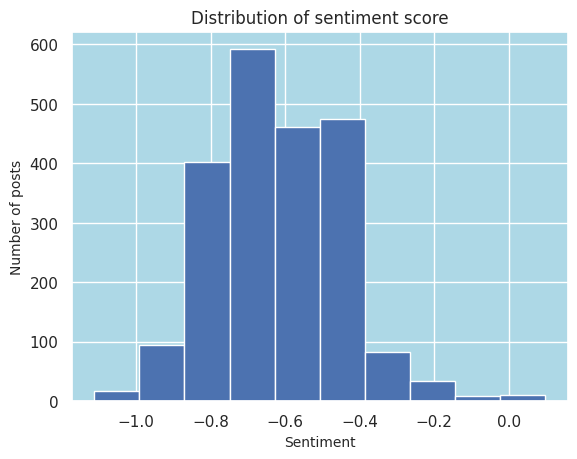

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'axes.facecolor':'lightblue'})
plt.hist(df['overall_sentiment'])
plt.xlabel("Sentiment", fontsize=10)
plt.ylabel("Number of posts", fontsize=10)
plt.title("Distribution of sentiment score")
plt.grid(True, color ='white')
plt.show()

Converting data into format suitable for Flourish

In [ ]:
import pandas as pd

bins = [ -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
labels = []
for i in range(10):
  labels.append((i))

df['sentiment_group'] = pd.cut(df['overall_sentiment'], bins=bins, labels=labels, include_lowest=True)
grouped = df.groupby('sentiment_group').size().reset_index(name='number_of_posts')
grouped.to_csv('anti_sentiment_groups.csv', index=False)




<ipython-input-44-c8ce6acec820>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('sentiment_group').size().reset_index(name='number_of_posts')


In [ ]:
grouped_data

,overall_sentiment
channel_id,
1182289683,0.133132
1066123382,-0.024762
1673823532,-0.095221
1827952089,-0.100108


In [ ]:
grouped_data = df.groupby('channel_id')['overall_sentiment'].mean().sort_values(ascending=False)
grouped_data.to_csv('grouped_data.csv', index=True)

In [ ]:
df.groupby('channel_id')['overall_polar_score'].mean().sort_values(ascending=False)

,overall_polar_score
channel_id,
1066123382,0.314168
1182289683,0.297257
1673823532,0.240042
1827952089,0.223148


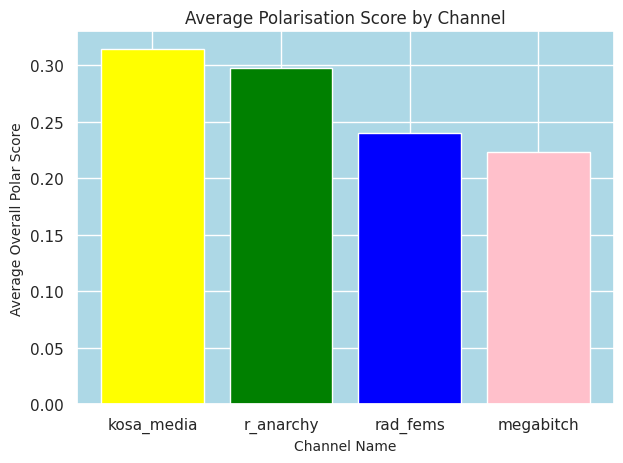

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

grouped_data = df.groupby('channel_id')['overall_polar_score'].mean().sort_values(ascending=False)

x_labels = [mentioned_posts_dict.get(channel_id, str(channel_id)) for channel_id in grouped_data.index]
plt.bar(x_labels, grouped_data.values)

plt.xlabel("Channel Name", fontsize=10)
plt.ylabel("Average Overall Polar Score", fontsize=10)
plt.title("Average Polarisation Score by Channel")
plt.tight_layout()
plt.ylim(bottom=0)
plt.show()

Lets find the most polarised posts

In [ ]:
df.groupby('channel_id')['overall_sentiment'].mean().sort_values(ascending=False)

,overall_sentiment
channel_id,
1182289683,0.133132
1066123382,-0.024762
1673823532,-0.095221
1827952089,-0.100108


# Creating a graph for the users

Getting ids of all users

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/anti_text_1000_anotherone.csv')
df2 = pd.read_csv('/content/text_1000_anotherone.csv')

In [ ]:
df['type'] = 'anti'
df2['type'] = 'fem'

In [ ]:
df = pd.concat([df, df2], ignore_index=True)

In [ ]:
df.shape

(3692, 19)

In [ ]:
inters_for_each_user_per_channel = {}
inters_for_each_user_overall = {}
inters_for_each_channel = {}
channels_users = {}
channel_type = {}

In [ ]:
channels = set(df['channel_id'])

In [ ]:
for channel in channels:
  inters_for_each_user_per_channel[channel] = {}

In [ ]:
import ast
user_ids = []
overall_amount = 0
df['commented_users'] = np.empty((len(df), 0)).tolist()
for i in df.index:
  df.at[i, 'comments'] = ast.literal_eval(df.at[i, 'comments'])
  channel = df.at[i, 'channel_id']
  for j in range(len(df.at[i, 'comments'])):
    if df.at[i, 'comments'][j]['user_id'] is None or df.at[i, 'comments'][j]['user_id'] == '':
      continue
    df.at[i, 'commented_users'].append(df.at[i, 'comments'][j]['user_id'])
    user_ids.append(df.at[i, 'comments'][j]['user_id'])
    user = df.at[i, 'comments'][j]['user_id']
    inters_for_each_user_per_channel[channel][user] = inters_for_each_user_per_channel[channel].get(user, 0) + 1
    inters_for_each_user_overall[user] = inters_for_each_user_overall.get(user, 0) + 1
    inters_for_each_channel[channel] = inters_for_each_channel.get(channel, 0) + 1
    channels_users[channel] = channels_users.get(channel, []) + [user]
    overall_amount += 1



In [ ]:
print(overall_amount)

196758


In [ ]:
df1 = df.groupby('channel_id')

Here data is in a format suitable for Flourish

In [ ]:

gr = pd.DataFrame(columns = ['channel', 'user', 'edge_color', 'type'])
gr_data = []

gr_summary = pd.DataFrame(columns = ['channel', 'user', 'num_of_mentions'])
gr_summary_data = []
fem_anti = {}

for main_node, users in channels_users.items():
    for user in set(users):
        gr_data.append(
            {
                "channel": mentioned_posts_dict.get(main_node, main_node),
                "user": user,
                "edge_color": inters_for_each_user_per_channel[main_node][user],
                "type" : next(iter(df1.get_group(main_node)['type'].dropna()), None)
            }
        )
        type_user = fem_anti.get(user, None)
        if type_user is None:
          type_user = next(iter(df1.get_group(main_node)['type'].dropna())), None
          fem_anti[user] = type_user
        elif type_user != next(iter(df1.get_group(main_node)['type'].dropna()), None) or type_user == 'both':
          fem_anti[user] = 'both'

        channel = main_node

        if     inters_for_each_user_per_channel[channel][user] == inters_for_each_user_overall[user]:
          channel = mentioned_posts_dict.get(main_node, main_node)
        else:
          channel = 'multiple'

        gr_summary_data.append(
            {
                "channel": channel,
                "user": user,
                'num_of_mentions': inters_for_each_user_overall[user],
                'type' : type_user
            }
        )

for channel in channels:
          gr_summary_data.append(
            {
                "channel_type": 'main_node',
                "user": channel,
                'num_of_mentions': inters_for_each_channel[channel]
            }
        )
gr = pd.DataFrame(gr_data)
gr_summary = pd.DataFrame(gr_summary_data)






In [ ]:
gr.to_csv('gr_data_users.csv', index=False)
gr_summary.to_csv('gr_summary_users.csv', index=False)

In [ ]:
gr_summary[gr_summary['channel'] == 'multiple']

,channel,user,num_of_mentions,channel_type
113,multiple,125616499,35,NaN
463,multiple,1789560479,7,NaN
676,multiple,703809882,495,NaN
1094,multiple,912396179,23,NaN
1206,multiple,1643204905,3,NaN
...,...,...,...,...
10785,multiple,454456044,12,NaN
10794,multiple,368079654,9,NaN
11094,multiple,467106503,22,NaN
11139,multiple,96828377,24,NaN


In [ ]:
gr_summary[gr_summary['type'] == 'both']

,channel,user,num_of_mentions,type,channel_type
6808,multiple,187208378,15,both,NaN
9485,multiple,169563165,6,both,NaN
9824,multiple,844192937,5,both,NaN
10657,multiple,284356551,10,both,NaN
11094,multiple,467106503,22,both,NaN


Stats for num of comments / num of unique users

In [ ]:
len(user_ids) - anti

164941

In [ ]:
len(user_ids) - fem

31817

In [ ]:
len(set(user_ids)) - fem

7149

In [ ]:
len(set(user_ids))

11166

Creating graphs for users

In [ ]:
user_ids_index = {num: idx for idx, num in enumerate(set(user_ids))}

In [ ]:
channels = set(df['channel_id'])

In [ ]:
import pandas as pd
import itertools

interaction_rows = []

for i in df.index:
    all_combos = list(itertools.combinations(set(df.at[i, 'commented_users']), 2))
    for f, s in all_combos:
        if f == s:
          continue
        if not f or not s:
            continue

        k = user_ids_index[f]
        m = user_ids_index[s]
        interaction = user_matrix[k][m]

        interaction_rows.append({
            'user1': f,
            'user2': s,
            'num_of_inter': interaction.num_of_inter,
            'channel_id': interaction.channel_id,
            'message_id': interaction.message_id
        })


interactions = pd.DataFrame(interaction_rows)

print(interactions.head(10))


In [ ]:
interactions.shape

(1207822, 5)

In [ ]:
interactions.to_json('fem_user_network.json', orient='records', lines=True)

In [ ]:
!pip install networkx


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(543923, 5)

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(crisp, source='user1', target='user2')

node_interactions = {}
for u, v, data in G.edges(data=True):
    node_interactions[u] = node_interactions.get(u, 0) + data['num_of_inter']
    node_interactions[v] = node_interactions.get(v, 0) + data['num_of_inter']

node_sizes = [node_interactions.get(node, 1) * 50 for node in G.nodes()]

In [ ]:
pos = nx.spring_layout(G)

In [ ]:

def graph_prep(crisp):
  norm = plt.Normalize(crisp['num_of_inter'].min(), crisp['num_of_inter'].max())
  color_map = {
      1066123382 : 'green',
      1182289683 : 'blue',
      1673823532 : 'orange',
      1827952089 : 'pink'
  }
  node_colors = []
  for node in G.nodes():
      # Get the corresponding channel_id for the node
      user_data = crisp[crisp['user1'] == node]
      if not user_data.empty:
          channel_id = user_data['channel_id'].values[0]
          node_colors.append(color_map.get(channel_id, 'gray'))
      else:
          user_data = crisp[crisp['user2'] == node]
          channel_id = user_data['channel_id'].values[0]
          node_colors.append(color_map.get(channel_id, 'gray'))
  return node_colors

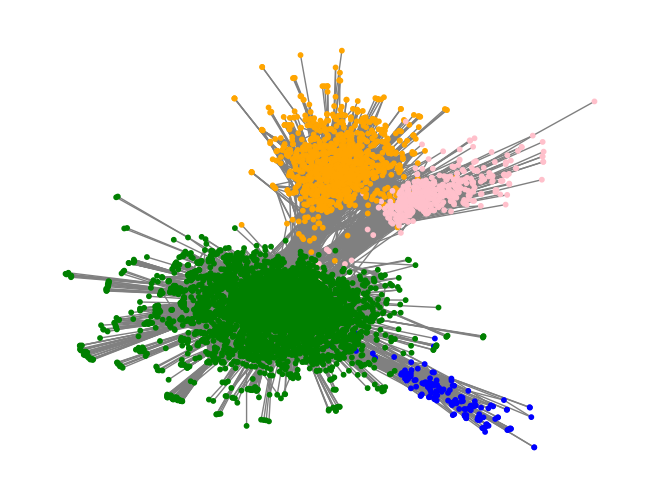

In [ ]:
node_colors = graph_prep(crisp)
nx.draw(G, pos, node_color=node_colors, node_size=10, font_size=15, edge_color='gray', width = 1)

plt.show()

# Creating graph for channels

In [ ]:
import pandas as pd
import ast

In [ ]:
df = pd.read_csv('/content/anti_text_1000_anotherone (2).csv')
df2 = pd.read_csv('/content/text_1000_anotherone (1).csv')


In [ ]:
df = pd.concat([df, df2], ignore_index=True)

In [ ]:
df1 = df.groupby('channel_id')

In [ ]:
channels = set(df['channel_id'])
print(channels)

{1900079682, 1673823532, 1429264495, 1824409104, 1921078737, 1182289683, 1066123382, 1827952089}


In [ ]:
mentioned_posts_dict ={} #названия каналов
mentioned_posts_count = {}

channels_posts = {}
channels_shapes = {}
values = []

which_main_node = {}
for channel in channels:
  posts = set((list((df1.get_group(channel)['mentioned_posts'].dropna().to_list()))))
  mentioned_channels = []
  mentioned_posts_count[channel] = {}
  which_main_node[channel] = -1
  for post in set(posts):
    if ast.literal_eval(post)[0][1] == channel:
      continue
    mentioned_posts_dict[ast.literal_eval(post)[0][1]] = ast.literal_eval(post)[0][0]
    mentioned_channels.append(ast.literal_eval(post)[0][1])
    if ast.literal_eval(post)[0][1] in which_main_node:
        which_main_node[ast.literal_eval(post)[0][1]] = 0
    else:
        which_main_node[ast.literal_eval(post)[0][1]] = channel

  channels_posts[channel] = list(set(mentioned_channels))

for channel in channels:
  posts = list(set((df1.get_group(channel)['original_channel_id'].dropna().astype(int).to_list())))
  posts_names = list(set((df1.get_group(channel)['original_channel_id'].dropna().astype(str).to_list())))
  mentioned_channels = []
  for post in posts:
    if post == channel:
      continue
    mentioned_posts_dict.get(post, -1)
    mentioned_channels.append(post)

    if post in which_main_node:
        which_main_node[post] = 0
    else:
        which_main_node[post] = channel
  channels_posts[channel].extend(mentioned_channels)
  channels_posts[channel] = list(set(channels_posts[channel]))




In [ ]:
mentioned_posts_dict = {}
mentioned_posts_dict[1921078737] = 'privatnyi_butylka'
mentioned_posts_dict[1900079682]= 'm_d_channel_1'
mentioned_posts_dict[1824409104] = 'Incel_Aesthetic'
mentioned_posts_dict[1429264495]= 'aviva_md'


In [ ]:

mentioned_posts_dict[1182289683] = 'r_anarchy'
mentioned_posts_dict[1827952089]= 'kosa_media'
mentioned_posts_dict[1673823532] = 'rad_fems'
mentioned_posts_dict[1827952089]= 'megabitch'

In [ ]:
mentioned_posts_count = {}
mentions_for_each_node = {}
values = []
number_of_mentioned_per_channel = {}
for channel in channels:
  posts = list(((df1.get_group(channel)['mentioned_posts'].dropna().to_list())))
  mentioned_channels = []
  mentioned_posts_count[channel] = {}
  mentions_for_each_node[channel] = 1
  number_of_mentioned_per_channel[channel] = 0
  for post in posts:
    post = ast.literal_eval(post)[0][1]
    if post == channel:
      continue
    number_of_mentioned_per_channel[channel] += 1
    mentioned_posts_count[channel][post] = mentioned_posts_count[channel].get(post, 0) + 1
    mentions_for_each_node[post] = mentions_for_each_node.get(post, 0) + 1
    values.append(mentioned_posts_count[channel][post])

for channel in channels:
  posts = list(((df1.get_group(channel)['original_channel_id'].dropna().astype(int).to_list())))
  mentioned_channels = []
  for post in posts:
    if post == channel:
      continue
    mentioned_posts_count[channel][post] = mentioned_posts_count[channel].get(post, 0) + 1
    mentions_for_each_node[post] = mentions_for_each_node.get(post, 0) + 1
    values.append(mentioned_posts_count[channel][post])
values = set(values)

mentiones_values = []

for i in mentions_for_each_node.values():
  mentiones_values.append(i)


In [ ]:
for i in  mentions_for_each_node.values():
  print(i) if i < 0 else None

Again converting everything for Flourish because the website cannot make a histrogram

In [ ]:
import pandas as pd

bins = [ -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
labels = []
for i in range(10):
  labels.append((i))

df['sentiment_group'] = pd.cut(df['overall_sentiment'], bins=bins, labels=labels, include_lowest=True)
grouped = df.groupby('sentiment_group').size().reset_index(name='number_of_posts')
grouped.to_csv('anti_sentiment_groups.csv', index=False)




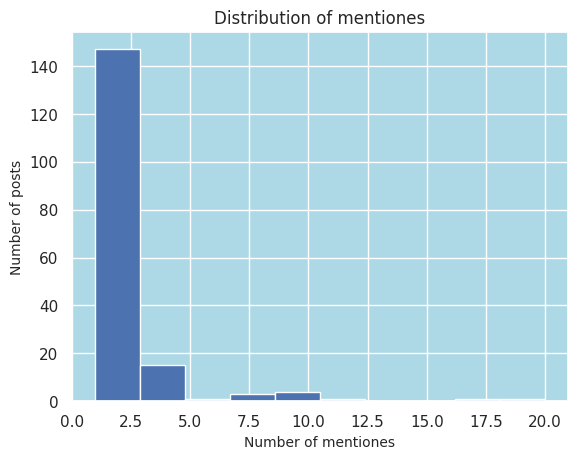

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set(rc={'axes.facecolor':'lightblue'})
plt.hist(mentiones_values)
plt.xlabel("Number of mentiones", fontsize=10)
plt.ylabel("Number of posts", fontsize=10)
plt.title("Distribution of mentiones")
plt.grid(True, color ='white')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
bins = np.linspace(0, 20, 9)
bin_labels = [f"({bins[i]:.1f}, {bins[i+1]:.1f}]" for i in range(len(bins)-1)]

bin_counts, _ = np.histogram(mentiones_values, bins=bins)


csv_data = [["Interval", "Count"]] + list(zip(bin_labels, bin_counts))


output_file = "binned_data.csv"
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_data)

print(f"CSV saved to {output_file}")

CSV saved to binned_data.csv


In [ ]:
import numpy as np
np.mean(mentiones_values)

1.8888888888888888

In [ ]:

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


gr = pd.DataFrame(columns = ['user1', 'user2', 'edge_color', 'type_u1', 'type_u2', 'num_of_mentionsu1', 'num_of_mentionsu2'])
gr_data = []
G = nx.Graph()
edge_colors = []
node_colors = []

for main_node, connected_nodes in channels_posts.items():
    for connected_node in set(connected_nodes):
        if connected_node == main_node:
            continue
        gr_data.append(
            {
                "user1": mentioned_posts_dict.get(main_node, main_node),
                "user2": mentioned_posts_dict.get(connected_node, connected_node),
                "edge_color": mentioned_posts_count[main_node][connected_node],
                "num_of_mentionsu1": mentions_for_each_node[main_node],
                "num_of_mentionsu2": mentions_for_each_node[connected_node]
            }
        )

main_nodes = set(channels_posts.keys())
connected_nodes = set(connected_nodes)
gr = pd.DataFrame(gr_data)

gr.drop_duplicates(inplace=True)
gr.reset_index(drop=True, inplace=True)
gr.to_csv('granti.csv')


#useless but necessary for flourish to get nodes different colors
node_mentions = pd.concat([
    gr[['user1', 'num_of_mentionsu1']].rename(columns={'user1': 'node', 'num_of_mentionsu1': 'num_of_mentions'}),
    gr[['user2', 'num_of_mentionsu2']].rename(columns={'user2': 'node', 'num_of_mentionsu2': 'num_of_mentions'})
])
node_mentions_summary = node_mentions.groupby('node', as_index=False).agg({'num_of_mentions': 'sum'})
node_mentions_summary['main_node'] = 0
node_mentions_summary['name'] = ''
for idx, row in node_mentions_summary.iterrows():

    node_mentions_summary.at[idx, 'main_node'] = mentioned_posts_dict.get(which_main_node.get(row['node'], row['node']), 'multiple')  # Handle missing keys with 'unknown'
    node_mentions_summary.at[idx, 'name'] = mentioned_posts_dict.get(row['node'], row['node'])  # Default to the node itself if no name exists
    node_mentions_summary.at[idx, 'num_of_mentions'] = abs(row['num_of_mentions'])

node_mentions_summary.to_csv('anti_node_mentions_summary.csv', index=False)


<ipython-input-61-759cba96e944>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Incel_Aesthetic' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  node_mentions_summary.at[idx, 'main_node'] = mentioned_posts_dict.get(which_main_node.get(row['node'], row['node']), 'multiple')  # Handle missing keys with 'unknown'


This is to make the graph in VisNet

In [ ]:

threshold = 25

#Normalize the edge colors
capped_weights = gr['edge_color'].apply(lambda x: min(x, threshold)).to_list()
norm = mcolors.Normalize(vmin=min(capped_weights), vmax=max(capped_weights))
cmap = plt.cm.viridis
edge_colors = [cmap(norm(weight)) for weight in capped_weights]

# Convert normalized colors to hex
edge_colors_hex = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b, _ in edge_colors]

for ind, row in gr.iterrows():
        main_node = row['user1']
        connected_node = row['user2']
        weight = row['edge_color']
        color = edge_colors_hex[ind]
        G.add_node(main_node, type="main", size = 60, color=main_node_colors[main_node], label = mentioned_posts_dict.get(main_node, main_node), shape = shapes.get(main_node), verticalalignment="center", horizontalalignment="center")
        G.add_node(connected_node, type="connected", color="gray", size = 30, label = mentioned_posts_dict.get(connected_node, connected_node), shape = shapes.get(connected_node), verticalalignment="center", horizontalalignment="center")
        G.add_edge(main_node, connected_node, color=color, size = 50, weight = 50)



node_size = [100 if node in main_nodes else 40 for node in G.nodes()]
for node in G.nodes():
    node_colors.append(main_node_colors.get(node, "lightgray"))


pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(8, 8))

nx.draw(G, pos, with_labels=False, node_size=node_size, edge_color=[color for color in edge_colors], ax=ax)
plt.title("Network Graph")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax)
plt.show()
nx.write_graphml(G, "social_network_colored1.graphml")


# Getting stats for graphs

In [ ]:
import pandas as pd

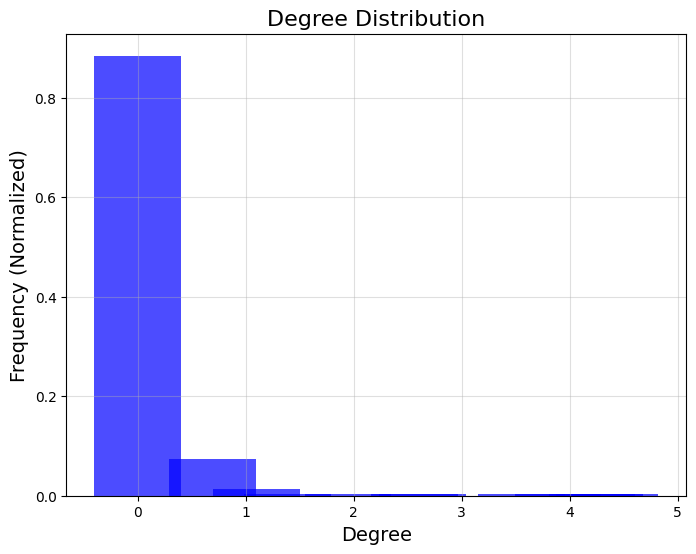

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

degrees = [G.degree(n) for n in G.nodes()]

degree_count = Counter(degrees)
total_nodes = len(G.nodes())
degree_distribution = {k: v / total_nodes for k, v in degree_count.items()}

plt.figure(figsize=(8, 6))
df = pd.DataFrame(columns = ['keys', 'values'])
df['keys'] = (np.log(list(degree_distribution.keys())))
df['values'] = (degree_distribution.values())
df.to_csv('degree_distrib_channels')
plt.bar(np.log(list(degree_distribution.keys())), degree_distribution.values(), color='blue', alpha=0.7)
plt.title("Degree Distribution", fontsize=16)
plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency (Normalized)", fontsize=14)
plt.grid(alpha=0.4)
plt.show()


In [ ]:
nodes = pd.read_csv('/content/Nodes for the grapg - Sheet1.csv')

In [ ]:
num_of_nodes = nodes.shape[0]

In [ ]:
links = pd.read_csv('/content/links for graph - Sheet1 (1).csv')

In [ ]:
num_of_edges = links.shape[0]

In [ ]:
import networkx as nx
G = nx.Graph()
for ind, row in links.iterrows():
  G.add_node(row['user1'], bipartite=0)
  G.add_node(row['user2'], bipartite=1)
  G.add_edge(row['user1'], row['user2'], weight = row['edge_color'])

In [ ]:

total_degree = sum(dict(G.degree()).values())
average_degree = total_degree / G.number_of_nodes()

print(f"Average degree (using degrees of nodes): {average_degree}")
articulation_points = list(nx.articulation_points(G))

print("Articulation Points:", *articulation_points)

Average degree (using degrees of nodes): 2.173076923076923
Articulation Points: rad_fems kosa_media megabitch femagainstwar MFRradfem ekaterina_mizulina Incel_Aesthetic aviva_md privatnyi_butylka r_anarchy


In [ ]:
fem = ['rad_fems', 'kosa_media', 'megabitch', 'femagainstwar', 'MFRradfem', 'r_anarchy']
anti = ['Incel_Aesthetic', 'aviva_md', 'privatnyi_butylka', 'm_d_channel_1']
nodes = fem + anti

In [ ]:
from itertools import combinations
def calc_foce_overlap(G):
    foci = nodes
    print(foci)
    foci_overlap = {}
    average_overlap = 0

    average_overlap_fem = 0
    n_fem = 0
    average_overlap_anti = 1
    n_anti = 0
    average_cross_community = 0
    n_cross_community = 0
    for f1, f2 in combinations(foci, 2):
        try:
          shared = len(set(G.neighbors(f1)) & set(G.neighbors(f2)))
        except:
          shared = 0
        foci_overlap[(f1, f2)] = shared
        average_overlap += shared

        if f1 in fem and f2 in fem:
            average_overlap_fem += shared
            n_fem += 1
        elif f1 in anti and f2 in anti:
            average_overlap_anti += shared
            n_anti += 1

        elif (f1 in anti and f2 in fem) or (f1 in fem and f2 in anti):
          average_cross_community += shared
          n_cross_community += 1


    average_overlap /= len(list(combinations(foci, 2)))

    print("Foci Overlap:", (foci_overlap))
    print("Average Foci Overlap:", average_overlap)
    print("Average Foci Overlap Fem:", average_overlap_fem / n_fem)
    print("Average Foci Overlap Anti:", average_overlap_anti / n_anti)
    print("Average Foci Overlap Cross Community:", average_cross_community / n_cross_community)
    return foci_overlap

##USERS

In [ ]:
gr = pd.read_csv("/content/Links.1737478799457.csv")

In [ ]:
gr.shape

(11310, 4)

In [ ]:
fem = ['rad_fems', 'kosa_media', 'megabitch', 'femagainstwar', 'MFRradfem', 'r_anarchy']
anti = ['Incel_Aesthetic', 'aviva_md', 'privatnyi_butylka', 'm_d_channel_1']

In [ ]:
gr.head()

,channel,user,edge_color,type
0,privatnyi_butylka,8.220181e+08,14,anti
1,privatnyi_butylka,6.334546e+09,4,anti
2,privatnyi_butylka,7.605903e+09,42,anti
3,privatnyi_butylka,7.069057e+09,794,anti
4,privatnyi_butylka,1.081836e+09,4,anti


In [ ]:
gr['channel_type'] = gr['channel'].apply(lambda x: 'fem' if x in fem else 'anti')

In [ ]:
nodes_users = pd.read_csv('/content/gr_users.csv')

In [ ]:
nodes_users['type'] = nodes_users['type'].apply(lambda x: 'anti' if x == "{'anti'}" else 'fem')

In [ ]:
import networkx as nx
U = nx.Graph()
for ind, row in gr.iterrows():
  U.add_node(row['channel'], bipartite=1)
  U.add_node(row['user'], bipartite=0)
  U.add_edge(row['channel'], row['user'], weight = row['edge_color'])

In [ ]:

total_degree = sum(dict(U.degree()).values())
average_degree = total_degree / U.number_of_nodes()

print(f"Average degree (using degrees of nodes): {average_degree}")
articulation_points = list(nx.articulation_points(U))

print("Articulation Points:", *articulation_points)

Average degree (using degrees of nodes): 2.028386633129716
Articulation Points: Incel_Aesthetic rad_fems megabitch kosa_media r_anarchy m_d_channel_1 aviva_md privatnyi_butylka


In [ ]:
overlaps = calc_foce_overlap(U)

['rad_fems', 'kosa_media', 'megabitch', 'femagainstwar', 'MFRradfem', 'r_anarchy', 'Incel_Aesthetic', 'aviva_md', 'privatnyi_butylka', 'm_d_channel_1']
Foci Overlap: {('rad_fems', 'kosa_media'): 30, ('rad_fems', 'megabitch'): 62, ('rad_fems', 'femagainstwar'): 0, ('rad_fems', 'MFRradfem'): 0, ('rad_fems', 'r_anarchy'): 1, ('rad_fems', 'Incel_Aesthetic'): 2, ('rad_fems', 'aviva_md'): 0, ('rad_fems', 'privatnyi_butylka'): 5, ('rad_fems', 'm_d_channel_1'): 0, ('kosa_media', 'megabitch'): 21, ('kosa_media', 'femagainstwar'): 0, ('kosa_media', 'MFRradfem'): 0, ('kosa_media', 'r_anarchy'): 16, ('kosa_media', 'Incel_Aesthetic'): 1, ('kosa_media', 'aviva_md'): 0, ('kosa_media', 'privatnyi_butylka'): 1, ('kosa_media', 'm_d_channel_1'): 1, ('megabitch', 'femagainstwar'): 0, ('megabitch', 'MFRradfem'): 0, ('megabitch', 'r_anarchy'): 0, ('megabitch', 'Incel_Aesthetic'): 3, ('megabitch', 'aviva_md'): 0, ('megabitch', 'privatnyi_butylka'): 1, ('megabitch', 'm_d_channel_1'): 0, ('femagainstwar', 'MFR

{('rad_fems', 'kosa_media'): 30,
 ('rad_fems', 'megabitch'): 62,
 ('rad_fems', 'femagainstwar'): 0,
 ('rad_fems', 'MFRradfem'): 0,
 ('rad_fems', 'r_anarchy'): 1,
 ('rad_fems', 'Incel_Aesthetic'): 2,
 ('rad_fems', 'aviva_md'): 0,
 ('rad_fems', 'privatnyi_butylka'): 5,
 ('rad_fems', 'm_d_channel_1'): 0,
 ('kosa_media', 'megabitch'): 21,
 ('kosa_media', 'femagainstwar'): 0,
 ('kosa_media', 'MFRradfem'): 0,
 ('kosa_media', 'r_anarchy'): 16,
 ('kosa_media', 'Incel_Aesthetic'): 1,
 ('kosa_media', 'aviva_md'): 0,
 ('kosa_media', 'privatnyi_butylka'): 1,
 ('kosa_media', 'm_d_channel_1'): 1,
 ('megabitch', 'femagainstwar'): 0,
 ('megabitch', 'MFRradfem'): 0,
 ('megabitch', 'r_anarchy'): 0,
 ('megabitch', 'Incel_Aesthetic'): 3,
 ('megabitch', 'aviva_md'): 0,
 ('megabitch', 'privatnyi_butylka'): 1,
 ('megabitch', 'm_d_channel_1'): 0,
 ('femagainstwar', 'MFRradfem'): 0,
 ('femagainstwar', 'r_anarchy'): 0,
 ('femagainstwar', 'Incel_Aesthetic'): 0,
 ('femagainstwar', 'aviva_md'): 0,
 ('femagainstwar

In [ ]:
i = 0
#the code is like this because i already know that there is only one component
component = []
for components in list(nx.connected_components(U)):
  if len(components) > 1:
    for channel in components:
      if channel in fem or channel in anti:
        component.append(channel)

print(*component)

rad_fems m_d_channel_1 kosa_media r_anarchy privatnyi_butylka Incel_Aesthetic aviva_md megabitch


In [ ]:
import numpy as np
weighted_degree = pd.DataFrame(U.degree(weight='weight'))
print("Weighted Degree:", np.mean(weighted_degree[1]))

Weighted Degree: 35.30201221703198


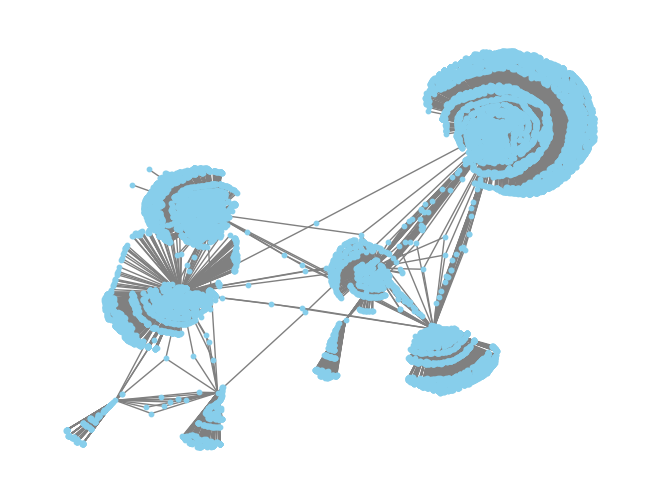

In [ ]:

import matplotlib.pyplot as plt
nx.draw(U, pos, with_labels=False, node_color="skyblue", edge_color="gray", node_size=10, font_size=10)
plt.show()